# Import Libraries and Load Data

In [1]:
#import libraries
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import re #regular expression
import pycountry_convert as pc #extraction continent name from country name
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import nltk
from textblob import TextBlob
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score

In [2]:
#load data saved locally
data = (pd.read_csv('C:\\Users\\Nnameka\\Downloads\\netflix-shows\\netflix_titles.csv',
                    index_col ='show_id', #dtype={'type': str,'title': str, 'director': str, 'cast':str,'country':str,  'release_year': int, 'rating':str, 
                                                # 'listed_in':str, 'description':str}, encoding='utf-8-sig'
                   ))

print('-'*40) #print dashes to separate the different displays
display(data.info())
print('-'*40)
display(data.describe())
print('-'*40)
print('No of observations & attributes of data:', data.shape)
print('-'*40)
display(data.nunique())
data.head(2);

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6234 entries, 81145628 to 70153404
Data columns (total 11 columns):
type            6234 non-null object
title           6234 non-null object
director        4265 non-null object
cast            5664 non-null object
country         5758 non-null object
date_added      6223 non-null object
release_year    6234 non-null int64
rating          6224 non-null object
duration        6234 non-null object
listed_in       6234 non-null object
description     6234 non-null object
dtypes: int64(1), object(10)
memory usage: 584.4+ KB


None

----------------------------------------


,release_year
count,6234.00000
mean,2013.35932
std,8.81162
min,1925.00000
25%,2013.00000
50%,2016.00000
75%,2018.00000
max,2020.00000


----------------------------------------
No of observations & attributes of data: (6234, 11)
----------------------------------------


type               2
title           6172
director        3301
cast            5469
country          554
date_added      1524
release_year      72
rating            14
duration         201
listed_in        461
description     6226
dtype: int64

# Preprocessing #

In [3]:
#Function to calculate null value and percentage null value
def check_null(data):
    Total = pd.Series(data.isnull().sum(), name='Total')
    Percent = pd.Series(round(data.isnull().sum()/data.shape[0]*100), name = 'Percent')
    null_table = pd.concat([Total, Percent],  axis = 1)
    null_table = null_table.transpose()
    return null_table

check_null(data)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
Total,0.0,0.0,1969.0,570.0,476.0,11.0,0.0,10.0,0.0,0.0,0.0
Percent,0.0,0.0,32.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Use Pandas-Profiling to explore the dataset with applicable viz
profile = ProfileReport(data)
profile

C:\Users\Nnameka\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,12
Number of observations,6234
Total Missing (%),4.1%
Total size in memory,584.6 KiB
Average record size in memory,96.0 B
Numeric,2
Categorical,10
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [5]:
#Drop null values in country and date_added
data.dropna(subset = ['country', 'date_added'], inplace =True)


#Convert date_added column to datetime object
data['date_added']= pd.to_datetime(data['date_added']).dt.strftime(f'%m-%d-%Y')
data['year_added']= pd.to_datetime(data['date_added']).dt.strftime(f'%Y')
data['year_added']=data['year_added'].astype(int)
data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added
show_id,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",09-09-2019,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,09-09-2016,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016
70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,09-08-2018,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018


In [6]:
#Define function to replace nan in categorical values with "Unknown"
def add_Unknown(col):
    col.replace('nan', 'Unknown')
    return col

#Replace nan with 'Unknown'
data['director'] = data['director'].astype(str).apply(add_Unknown)
data['cast'] = data['cast'].astype(str).apply(add_Unknown)

In [7]:
def clean_col(data):
    data = data.strip()
    data = re.sub("[\W0-9]", " ", data)
    return data
    

In [8]:
data['type'].apply(clean_col)

show_id
81145628      Movie
80117401      Movie
70234439    TV Show
80058654    TV Show
80125979      Movie
             ...   
80162994    TV Show
80186475    TV Show
70272742    TV Show
80067942    TV Show
70136122    TV Show
Name: type, Length: 5749, dtype: object

In [9]:
#The MF function above suddenlystopped working
data['director'] = data['director'].astype(str).replace('nan','Unknown')
data['cast'] = data['cast'].astype(str).replace('nan','Unknown')

In [10]:
data.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749 entries, 81145628 to 70136122
Data columns (total 12 columns):
type            5749 non-null object
title           5749 non-null object
director        5749 non-null object
cast            5749 non-null object
country         5749 non-null object
date_added      5749 non-null object
release_year    5749 non-null int64
rating          5743 non-null object
duration        5749 non-null object
listed_in       5749 non-null object
description     5749 non-null object
year_added      5749 non-null int32
dtypes: int32(1), int64(1), object(10)
memory usage: 561.4+ KB


In [11]:
country_dict = {'Soviet Union':'Russia', 'West Germany':'Germany'}
#Extract one country per observation
data['country'] =data['country'].apply(lambda x: x.split(',')[0]).replace(country_dict)
data['country'].value_counts();

In [12]:
#Defined function to create continent column
def continent(col):
    alpha2 = pc.country_name_to_country_alpha2(col)
    cont_code = pc.country_alpha2_to_continent_code(alpha2)
    cont_name = pc.convert_continent_code_to_continent_name(cont_code)
    return cont_name

#Create continent column
data['continent'] = data['country'].apply(continent)

data.groupby('continent')['continent','country', 'type'].head(2);

In [13]:
data.head(2)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,continent
show_id,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",United States,09-09-2019,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,North America
80117401,Movie,Jandino: Whatever it Takes,Unknown,Jandino Asporaat,United Kingdom,09-09-2016,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,Europe


In [14]:
class_dict = ({'Comedies, Cult Movies, Sports Movies':'Comedy','Action & Adventure, Sports Movies':'Action',
               'British TV Shows, Romantic TV Shows, TV Dramas':'Romance',
               'Dramas, Horror Movies, Music & Musicals':'Horror',
               'International TV Shows, Stand-Up Comedy & Talk Shows':'Comedy','Classic & Cult TV, Crime TV Shows, TV Dramas':'Action',
               'Crime TV Shows, TV Action & Adventure, TV Sci-Fi & Fantasy':'Action','International Movies':'Drama',
               'International TV Shows, Spanish-Language TV Shows, TV Horror':'Horror',
               'Action & Adventure, Anime Features, Horror Movies':'Animation','Action & Adventure, Comedies, Horror Movies':'Horror',
               'Crime TV Shows, International TV Shows, Reality TV':'Reality Show',
               'Children & Family Movies, Dramas, Music & Musicals':'Children & Family',
               'Comedies, Independent Movies, Music & Musicals':'Musical',
               'Docuseries, Science & Nature TV, TV Dramas':'Documentary','Anime Features, Romantic Movies':'Animation',
               'International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows':'Reality Show',
               'Anime Series, Crime TV Shows, TV Thrillers':'Animation',
               'Dramas, Faith & Spirituality, Romantic Movies':'Romance','British TV Shows, Docuseries, TV Comedies':'Documentary',
               'Cult Movies, Independent Movies, Thrillers':'Action','British TV Shows, International TV Shows, TV Horror':'Horror',
               'Action & Adventure, Children & Family Movies, Dramas':'Action',"Classic & Cult TV, Kids' TV, TV Comedies":'Action',
               'Documentaries':'Documentary','Stand-Up Comedy' : 'Comedy', 'Dramas, International Movies':'Drama',
               'Comedies, Dramas, International Movies':'Drama','British TV Shows, TV Dramas, TV Sci-Fi & Fantasy':'Sci-Fi',
               'Stand-Up Comedy & Talk Shows, TV Mysteries, TV Sci-Fi & Fantasy' :'Comedy', 
               'British TV Shows, Docuseries, Reality TV':'Reality Show','International TV Shows': 'Reality Show',
               'Dramas, Independent Movies, International Movies':'Drama', 'Classic Movies, Cult Movies, Documentaries':'Action',
               'Classic Movies, Dramas, LGBTQ Movies':'Gay & Lesbians','Reality TV, Spanish-Language TV Shows':'Reality Show',
               "Kids' TV":'Children & Family', 'Comedies, Dramas, Music & Musicals':'Musical','Action & Adventure': 'Action', 
               'Classic Movies, International Movies':'Action', 'Classic Movies, Horror Movies, Thrillers ':'Horror' ,
               'Children & Family Movies, Faith & Spirituality':'Children & Family', 'Classic Movies, Horror Movies, Thrillers':'Horror',
               'TV Horror, TV Mysteries, Teen TV Shows':'Horror','Documentaries, International Movies':'Documentary',
               'Action & Adventure, Romantic Movies, Sci-Fi & Fantasy':'Action', 'Children & Family Movies, Comedies':'Children & Family',
               'Action & Adventure, Romantic Movies, Sci-Fi & Fantasy':'Romance','Comedies, International Movies':'Comedy',
               "Kids' TV, Reality TV, Science & Nature TV ":'Children & Family',
               'Dramas, International Movies, Romantic Movies':'Romance', 'TV Comedies, Teen TV Shows':'Comedy',
               'Horror Movies, Independent Movies, Sci-Fi & Fantasy':'Horror','Gay & Lesbains':'Gay & Lesbians',
               "Classic & Cult TV, Kids' TV, Spanish-Language TV Shows":'Action', 'TV Action & Adventure':'Action', 
               'Comedies, Cult Movies, LGBTQ Movies':'Gay & Lesbians', 'TV Dramas, TV Mysteries, TV Thrillers':'Reality Show',
               'Action & Adventure, Classic Movies, International Movies':'Action',
               'Action & Adventure, International Movies, Thrillers':'Action'
              'Comedies','Crime TV Shows, International TV Shows, Spanish-Language TV Shows':'Action',
       'International Movies, Sci-Fi & Fantasy, Thrillers':'Sci-Fi',
       'Docuseries, Science & Nature TV':'Documentary', 'Action & Adventure, Thrillers':'Action',
       'Action & Adventure, Dramas, International Movies':'Action',
       'Cult Movies, Dramas, Independent Movies':'Action',
       'Comedies, Independent Movies, Romantic Movies':'Romance',
       'Action & Adventure, Comedies, International Movies':'Action', 'Horror Movies, Thrillers':'Documentary',
       'Dramas, Independent Movies':'Drama',
       'Dramas, Independent Movies, Romantic Movies':'Romance',
       'Horror Movies, International Movies':'Horror',
       'Children & Family Movies, Comedies, Sci-Fi & Fantasy':'Children & Family',
       'Comedies, Romantic Movies':'Romance',
       'Dramas, International Movies, Thrillers':'Drama', 
       'International TV Shows, TV Dramas, TV Thrillers':'Drama',
       'Action & Adventure, Comedies, Independent Movies':'Action',
       'Comedies, International Movies, Romantic Movies':'Comedy', 'Romance':'Romance',
       'Comedies, Dramas':'Comedy', 'Romantic TV Shows, TV Comedies, TV Dramas':'Romance',
       'Horror Movies':'Horror', 'Dramas, Romantic Movies':'Romance',
       'Action & Adventure, Sci-Fi & Fantasy':'Action',
       'Crime TV Shows, TV Dramas, TV Mysteries':'Drama', 'TV Comedies':'Comedy',
       'Children & Family Movies, Dramas, Docuseries':'Children & Family',
       "Kids' TV, TV Comedies":'Comedy',
       'British TV Shows, Docuseries, International TV Shows':'Documentary',
       'Action & Adventure, International Movies':'Action',
       'Children & Family Movies, Music & Musicals':'Children & Family',
       'International Movies, Thrillers':'Drama',
       'Action & Adventure, International Movies, Sci-Fi & Fantasy':'Action',
       'Action & Adventure, Dramas':'Action',
       'International TV Shows, Reality TV, Spanish-Language TV Shows':'Reality Show',
       'International TV Shows, TV Action & Adventure, TV Dramas':'Action',
       'Dramas, Sci-Fi & Fantasy, Thrillers':'Sci-Fi',
       'Anime Features, Music & Musicals, Sci-Fi & Fantasy':'Animation',
       'TV Comedies, TV Dramas, Teen TV Shows':'Comedy',
       'Children & Family Movies, Dramas, Faith & Spirituality':'Children & Family',
       'International Movies, Romantic Movies':'Romance',
       'Comedies, International Movies, Music & Musicals':'Musical',
       'Children & Family Movies':'Children & Family',
       'Comedies, Independent Movies, Thrillers':'Comedy',
       'Comedies, Horror Movies, International Movies':'Comedy',
       'TV Comedies, TV Dramas':'Comedy', 'Documentaries, Music & Musicals':'Documentary',
       'Independent Movies, International Movies, Thrillers':'Drama',
       'Dramas, Independent Movies, Thrillers':'Drama',
       'International TV Shows, Korean TV Shows, TV Action & Adventure':'Drama',
       'Anime Series, International TV Shows':'Animation',
       'TV Comedies, TV Dramas, TV Mysteries':'Drama',
       'Crime TV Shows, TV Comedies, TV Dramas':'Drama',
       'British TV Shows, Crime TV Shows, International TV Shows':'Action',
       'Dramas, Independent Movies, LGBTQ Movies':'Gay & Lesbians',
       'International TV Shows, TV Comedies, TV Dramas':'Drama',
       'TV Horror, Teen TV Shows':'Horror',
       'Crime TV Shows, International TV Shows, TV Action & Adventure':'Action',
       'Dramas, Thrillers':'Drama',
       'Independent Movies, Sci-Fi & Fantasy, Thrillers':'Sci-Fi',
       'International TV Shows, Korean TV Shows, Romantic TV Shows':'Romance',
       'International TV Shows, TV Dramas':'Drama',
       'Horror Movies, Independent Movies':'Horror',
       'British TV Shows, Crime TV Shows, Docuseries':'Documentary',
       'Action & Adventure, Comedies, Cult Movies':'Action', 'Movies':'Action',
       "Anime Series, Kids' TV":'Animation', 'Crime TV Shows, Docuseries':'Animation',
       'Documentaries, International Movies, Music & Musicals':'Documentary',
       'Reality TV':'Reality Show', 'Crime TV Shows, International TV Shows, TV Dramas':'Reality Show',
       'British TV Shows, International TV Shows, Reality TV':'Reality Show', 'Dramas':'Drama',
        'Action & Adventure, Independent Movies':'Action',
      'British TV Shows, Crime TV Shows, TV Dramas':'Action',
        'Docuseries, International TV Shows':'',
        'Stand-Up Comedy & Talk Shows, TV Comedies':'Comedy',
       'Comedies, Dramas, Independent Movies':'Comedy',
       'International TV Shows, Romantic TV Shows, TV Action & Adventure':'Romance',
       'International TV Shows, Spanish-Language TV Shows, TV Dramas':'Drama',
       'Children & Family Movies, Comedies, Romantic Movies':'Children & Family',
       'Crime TV Shows, TV Dramas':'Drama',
       'TV Action & Adventure, TV Dramas, TV Sci-Fi & Fantasy':'Drama',
       'International TV Shows, Korean TV Shows, TV Dramas':'Drama',
       'Comedies, Cult Movies, Dramas':'Drama',
       'Classic Movies, Comedies, Cult Movies':'Horror', 'Comedies, Cult Movies':'Drama',
       'Dramas, Romantic Movies, Sci-Fi & Fantasy':'Drama',
       'Horror Movies, Independent Movies, Thrillers':'Drama',
       'Action & Adventure, Romantic Movies':'Action',
       'Action & Adventure, Comedies':'Action',
       'Documentaries, International Movies, Sports Movies':'Documentary',
       'Independent Movies, Thrillers':'Drama',
       'Children & Family Movies, Comedies, Dramas':'Drama',
       'Comedies, Cult Movies, Horror Movies':'Comedy',
       'Comedies, Independent Movies, International Movies':'Comedy',
       'Dramas, International Movies, Sports Movies':'Drama',
       'Horror Movies, International Movies, Thrillers':'Drama',
       'Action & Adventure, Anime Features, International Movies':'Drama',
       'Dramas, International Movies, Music & Musicals':'Drama',
       'Romantic TV Shows, TV Dramas':'Romance', "Kids' TV, Reality TV, Science & Nature TV":'Children & Family',
      'Children & Family Movies, Dramas':'Romance', 'Docuseries':'Documentary',
       'International TV Shows, TV Dramas, TV Horror':'Drama',
       'Docuseries, Reality TV':'Documentary', 'Comedies, Horror Movies':'Documentary',
       'Documentaries, Sports Movies':'Documentary',
       'Classic Movies, Comedies, Independent Movies':'Drama',
       'Documentaries, LGBTQ Movies, Music & Musicals':'Gay & Lesbians',
       'British TV Shows, Docuseries':'Documentary',
       'British TV Shows, TV Horror, TV Thrillers':'Horror',
       'International TV Shows, Romantic TV Shows, TV Comedies':'Romance',
       'Children & Family Movies, Dramas, Sports Movies':'Children & Family',
       'International TV Shows, Romantic TV Shows, TV Dramas':'Romance',
       'Documentaries, LGBTQ Movies':'Documentary',
       'Crime TV Shows, Spanish-Language TV Shows, TV Action & Adventure':'Action',
       'Classic & Cult TV, TV Comedies':'Comedy',
       'Classic & Cult TV, TV Sci-Fi & Fantasy':'Horror',
       'Crime TV Shows, TV Action & Adventure, TV Thrillers':'Action',
       'Crime TV Shows, TV Dramas, TV Horror':'Horror',
       "Kids' TV, TV Action & Adventure":'Action',
       "Kids' TV, Korean TV Shows, TV Comedies":'Children and Family',
       'TV Comedies, TV Sci-Fi & Fantasy, Teen TV Shows':'Sci-Fi',
       "Kids' TV, TV Comedies, TV Dramas":'Drama',
       'British TV Shows, TV Comedies, TV Dramas':'Reality Show',
       'Romantic TV Shows, TV Action & Adventure, TV Dramas':'Action',
       'TV Comedies, TV Dramas, TV Horror':'Horror',
        'TV Horror, TV Mysteries, TV Thrillers':'Horror',
       'TV Action & Adventure, TV Comedies, TV Sci-Fi & Fantasy':'Action',
       'Crime TV Shows, TV Comedies, Teen TV Shows':'Comedy',
       'Crime TV Shows, TV Horror, TV Mysteries':'Horror',
       'Classic & Cult TV, TV Action & Adventure, TV Dramas':'Action',
       'British TV Shows, Classic & Cult TV, TV Comedies':'Action',
       "British TV Shows, Kids' TV, TV Thrillers":'Reality Show',
       'Anime Series, TV Horror, TV Thrillers':'Animation',
       "Kids' TV, TV Dramas, Teen TV Shows":'Drama',
       'British TV Shows, Classic & Cult TV, International TV Shows':'Action',
       'Crime TV Shows, TV Action & Adventure':'Action',
       'Docuseries, Reality TV, Science & Nature TV':'Documentary',
       'Reality TV, TV Horror, TV Thrillers':'Horror',
       'TV Dramas, TV Sci-Fi & Fantasy, TV Thrillers':'Sci-Fi',
       'Classic & Cult TV, TV Action & Adventure, TV Sci-Fi & Fantasy':'Action',
       "Kids' TV, TV Dramas":'Children & Family',
       'Classic & Cult TV, TV Action & Adventure, TV Horror':'Horror',
       'TV Comedies, TV Horror, TV Thrillers':'Horror',
       "Kids' TV, Spanish-Language TV Shows, Teen TV Shows":'Children & Family',
       "British TV Shows, Kids' TV, TV Dramas":'Reality Show',
        'Comedies, Horror Movies, Sci-Fi & Fantasy':'Horror', 'Independent Movies':'Drama',
       'Action & Adventure, Children & Family Movies, Classic Movies':'Action',
       'Classic Movies, Cult Movies, Dramas':'Action',
       'Action & Adventure, Cult Movies, Sci-Fi & Fantasy':'Action',
       'Comedies, Music & Musicals, Romantic Movies':'Musical',
       'TV Action & Adventure, TV Dramas':'Action',
       'International TV Shows, Korean TV Shows, Stand-Up Comedy & Talk Shows':'Comedy',
       'TV Action & Adventure, TV Mysteries, TV Sci-Fi & Fantasy':'Action',
       'British TV Shows, Reality TV':'Reality Show',
       'Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows':'Romance',
       'TV Action & Adventure, TV Dramas, TV Horror':'Action',
       'Classic Movies, Comedies, International Movies':'Comedy',
       'Action & Adventure, Cult Movies':'Action', 'Docuseries, TV Comedies':'Documentary',
       'Action & Adventure, Faith & Spirituality, Sci-Fi & Fantasy':'Action',
       'Crime TV Shows, Romantic TV Shows, TV Dramas':'Romance',
       'British TV Shows, International TV Shows, TV Action & Adventure':'Action',
       'Children & Family Movies, Sports Movies':'Children & Family',
       'International TV Shows, Spanish-Language TV Shows, TV Action & Adventure':'Action',
       'Anime Series, International TV Shows, TV Thrillers':'Animation',
       'Sci-Fi & Fantasy':'Sci-Fi', 'Crime TV Shows, TV Comedies':'Sci-Fi',
       'Reality TV, TV Comedies':'Reality Show',
       'Action & Adventure, Documentaries, Sports Movies':'Action',
       'International TV Shows, TV Action & Adventure, TV Sci-Fi & Fantasy':'Action',
       'Action & Adventure, Dramas, Faith & Spirituality':'Action',
       'Children & Family Movies, Documentaries, Sports Movies':'Children & Family',
       "Crime TV Shows, Kids' TV, TV Comedies":'Childrn & Family',
       'Children & Family Movies, Comedies, LGBTQ Movies':'Gay & Lesbian',
       'TV Action & Adventure, TV Sci-Fi & Fantasy':'Action',
       'Dramas, Horror Movies, Sci-Fi & Fantasy':'Drama',
       'International TV Shows, TV Mysteries, TV Thrillers':'Drama',
       'Action & Adventure, Cult Movies, Dramas':'Drama',
       'TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows':'Drama',
       'International TV Shows, Reality TV, Romantic TV Shows':'Romance',
       'Independent Movies, Romantic Movies':'Romance',
       'TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy':'Drama',
       'Children & Family Movies, Comedies, Faith & Spirituality':'Children & Family',
       'Romantic TV Shows, TV Dramas, TV Sci-Fi & Fantasy':'Romance',
       'Dramas, Faith & Spirituality, Independent Movies':'Drama',
       'International Movies, Romantic Movies, Sci-Fi & Fantasy':'Romance',
       'Anime Series, Romantic TV Shows, Teen TV Shows':'Animation',
       'Classic & Cult TV, TV Horror, TV Mysteries':'Horror',
       'TV Action & Adventure, TV Comedies':'Action',
       'TV Sci-Fi & Fantasy, TV Thrillers':'Sci-Fi',
        'Children & Family Movies, Independent Movies':'Children& Family',
       'Comedies, Independent Movies, LGBTQ Movies':'Gay & Lesbians',
       'Crime TV Shows, TV Dramas, TV Sci-Fi & Fantasy':'Sci-Fi',
       'Docuseries, Reality TV, Teen TV Shows':'Documentary',
       'Anime Series, International TV Shows, TV Horror':'Animation',
       'Comedies, Dramas, Sports Movies':'Drama',
       'Comedies, Dramas, Faith & Spirituality':'Drama',
       'Dramas, Sci-Fi & Fantasy':'Sci-Fi',
       'Action & Adventure, Anime Features, Children & Family Movies':'Action',
       'Classic & Cult TV, Crime TV Shows, International TV Shows':'Action',
       'Crime TV Shows, TV Action & Adventure, TV Comedies':'Action',
       'International TV Shows, Reality TV, TV Comedies':'Reality Show',
       'Anime Series, Teen TV Shows':'Animation', 'Horror Movies, Sci-Fi & Fantasy':'Horror',
       'Cult Movies, Horror Movies, Thrillers':'Horror',
       'Classic Movies, Dramas, Music & Musicals':'Musical',
       'Classic Movies, Comedies, Romantic Movies':'Romance',
       'Classic Movies, Independent Movies, Thrillers':'Drama',
        'Documentaries, Faith & Spirituality, Music & Musicals':'Documentary',
       "British TV Shows, Kids' TV":'Children & Family',
       'International TV Shows, Spanish-Language TV Shows, TV Comedies':'Reality Show',
       'British TV Shows, International TV Shows, TV Dramas':'Drama',
       'Comedies, Horror Movies, Independent Movies':'Horror',
       'British TV Shows, International TV Shows, Stand-Up Comedy & Talk Shows':'Children & Family',
       'Action & Adventure, Children & Family Movies, Independent Movies':'Children & Family',
       'Children & Family Movies, Comedies, Cult Movies':'Children & Family',
       'TV Action & Adventure, TV Horror, TV Sci-Fi & Fantasy':'Sci-Fi',
       'Anime Features, Children & Family Movies, International Movies':'Animation',
       'TV Comedies, TV Sci-Fi & Fantasy':'Sci-Fi',
       'Documentaries, Dramas, International Movies':'Drama',
       'Reality TV, Teen TV Shows':'Reality Show', 'Reality TV, Science & Nature TV':'Reality Show',
       'Children & Family Movies, Dramas, Independent Movies':'Drama',
       'International TV Shows, TV Horror, TV Thrillers':'Horror',
       'International Movies, Sports Movies':'Sports',
       'International Movies, Music & Musicals':'Musical',
       'Children & Family Movies, Documentaries, International Movies':'Children & Family',
       'Comedies, Faith & Spirituality, Romantic Movies':'Romance',
       'Anime Features, International Movies':'Animation',
       'Horror Movies, International Movies, Romantic Movies':'Horror',
       'Action & Adventure, Horror Movies, Independent Movies':'Horror',
       'Documentaries, Faith & Spirituality, International Movies':'Documentary',
       'Music & Musicals, Stand-Up Comedy':'Musical', 'Romantic Movies':'Romance',
       'Crime TV Shows, Docuseries, Science & Nature TV':'Documentary',
       'Dramas, Independent Movies, Music & Musicals':'Musical',
       'International Movies, Music & Musicals, Thrillers':'Musical',
       'Action & Adventure, Children & Family Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'Dramas, LGBTQ Movies':'Gay & Lesbian', 'Documentaries, Faith & Spirituality':'Gay & Lesbian',
       'ActionComedies':'Comedy', 'Classic Movies, Cult Movies, Horror Movies':'Action',
       'Crime TV Shows, Spanish-Language TV Shows, TV Dramas':'Drama',
       'Dramas, Music & Musicals, Romantic Movies':'Musical',
       'Action & Adventure, International Movies, Sports Movies':'Action',
       'Action & Adventure, Children & Family Movies':'Action',
       'Crime TV Shows, International TV Shows, Romantic TV Shows':'Romance',
       'International TV Shows, TV Dramas, TV Sci-Fi & Fantasy':'Drama',
       'Comedies, Faith & Spirituality, International Movies':'Comedy',
       'TV Action & Adventure, TV Dramas, TV Mysteries':'Action',
       'Documentaries, Horror Movies':'Documentary',
       "Kids' TV, TV Action & Adventure, TV Sci-Fi & Fantasy":'Sci-Fi',
       'Classic Movies, Dramas, Thrillers':'Drama',
       'Docuseries, International TV Shows, Spanish-Language TV Shows':'Documentary',
       'Stand-Up Comedy & Talk Shows':'Comedy',
       'Anime Features, Children & Family Movies':'Children & Family',
       'Children & Family Movies, Classic Movies, Comedies':'Children & Family',
       'British TV Shows, Reality TV, Romantic TV Shows':'Romance',
       'Classic Movies, Comedies, Dramas':'Drama',
       'Action & Adventure, Horror Movies, International Movies':'Action',
       'TV Dramas, TV Sci-Fi & Fantasy':'Drama', 'TV Shows':'Reality Show',
       'Horror Movies, LGBTQ Movies, Thrillers':'Gay & Lesbian',
       'International TV Shows, Korean TV Shows, Reality TV':'Reality Show',
       'Documentaries, International Movies, LGBTQ Movies':'Gay & Lesbian',
       'Crime TV Shows, Docuseries, TV Mysteries':'Documentary',
       'Dramas, Independent Movies, Sports Movies':'Sports',
       'Romantic TV Shows, Spanish-Language TV Shows, TV Dramas':'Romance',
       'Action & Adventure, Sci-Fi & Fantasy, Thrillers':'Sci-Fi', 'Sports Movies':'Sports',
       'Children & Family Movies, Comedies, International Movies':'Children & Family',
       "British TV Shows, Kids' TV, TV Comedies":'Reality Show',
       "Kids' TV, Spanish-Language TV Shows":'Children & Family',
       'Action & Adventure, Anime Features, Classic Movies':'Animation',
       'Comedies, Cult Movies, Independent Movies':'Horror',
       'Action & Adventure, Comedies, Dramas':'Action', 'TV Dramas, Teen TV Shows':'Action',
       'Action & Adventure, Independent Movies, International Movies':'Action',
       'Classic & Cult TV, TV Dramas, TV Sci-Fi & Fantasy':'Sci-Fi',
       'Action & Adventure, Cult Movies, International Movies':'Action',
       'International TV Shows, TV Horror, TV Mysteries':'Reality Show',
       'British TV Shows, International TV Shows, TV Comedies':'Reality Show',
       'Action & Adventure, Horror Movies':'Action',
       'Crime TV Shows, TV Dramas, TV Thrillers':'Drama',
       'Classic Movies, Documentaries':'Documentary',
        'Dramas, International Movies, LGBTQ Movies':'Gay & Lesbians',
       'Action & Adventure, Classic Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'Classic Movies, Comedies, Music & Musicals':'Musical',
       'Action & Adventure, Horror Movies, Sci-Fi & Fantasy':'Action',
       'Action & Adventure, Classic Movies, Cult Movies':'Action',
       'Anime Series, Romantic TV Shows':'Animation',
       'Action & Adventure, Classic Movies, Dramas':'Action',
       'Action & Adventure, Classic Movies, Comedies':'Action',
       'Dramas, Music & Musicals':'Musical',
       'Dramas, Music & Musicals, Sports Movies':'Drama',
       'International TV Shows, TV Dramas, TV Mysteries':'Drama',
       'International Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'Action & Adventure, Comedies, Music & Musicals':'Musical',
       'Children & Family Movies, Comedies, Music & Musicals':'Musical',
       'Children & Family Movies, Documentaries':'Documentary',
       'Comedies, LGBTQ Movies':'Gay & Lesbians',
       'Crime TV Shows, International TV Shows, TV Comedies':'Reality Show',
               'Horror Movies, Independent Movies, International Movies':'Horror',
       'Comedies, Dramas, Romantic Movies':'Drama', 'Comedies, Sci-Fi & Fantasy':'Sci-Fi',
       'Comedies, Sports Movies':'Sports',
       'Classic Movies, Comedies, Sports Movies':'Sports',
       'Classic Movies, Dramas, Independent Movies':'Drama',
       'Cult Movies, Dramas, Thrillers':'Drama',
       'Comedies, International Movies, LGBTQ Movies':'Gay & Lesbians',
       'International TV Shows, TV Dramas, Teen TV Shows':'Drama',
       'Spanish-Language TV Shows, TV Dramas':'Drama',
       'Romantic TV Shows, Spanish-Language TV Shows, TV Comedies':'Romance',
       'Action & Adventure, Dramas, Independent Movies':'Drama',
       'Crime TV Shows, TV Action & Adventure, TV Dramas':'Drama',
       'Docuseries, International TV Shows, Reality TV':'Documentary',
       'Action & Adventure, Independent Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'International TV Shows, Romantic TV Shows':'Romance',
       'Anime Features, International Movies, Romantic Movies':'Animation',
       'Anime Series, International TV Shows, Teen TV Shows':'Animation',
       'Docuseries, Spanish-Language TV Shows':'Documentary',
       'TV Horror, TV Mysteries, TV Sci-Fi & Fantasy':'Horror',
       'International TV Shows, TV Action & Adventure, TV Comedies':'Reality Show',
       'Classic Movies, Dramas, Romantic Movies':'Romance',
       'Classic Movies, Dramas':'Drama', 'Action & Adventure, Classic Movies':'Drama',
       'Gay & Lesbian':'Gay & Lesbians', 'ActionComedies':'Action',
                 'Dramas, Independent Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'Action & Adventure, International Movies, Romantic Movies':'Action',
       'Comedies, International Movies, Sports Movies':'Sports',
       'Action & Adventure, Anime Features, Sci-Fi & Fantasy':'Sci-Fi',
       'Anime Series, Crime TV Shows, International TV Shows':'Animation',
       'Docuseries, Stand-Up Comedy & Talk Shows':'Documentary',
       'Crime TV Shows, International TV Shows, Korean TV Shows':'Reality Show',
       'Horror Movies, International Movies, Sci-Fi & Fantasy':'Horror',
       'Music & Musicals':'Musical', 'Children & Family Movies, Sci-Fi & Fantasy':'Children & Family',
       'British TV Shows, Docuseries, Science & Nature TV':'Documentary',
       'Cult Movies, Horror Movies':'Horror',
       'Classic Movies, Dramas, International Movies':'Drama',
       'Sci-Fi & Fantasy, Thrillers':'Sci-Fi', "Kids' TV, Korean TV Shows":'Children & Family',
       'Classic Movies, Dramas, Sports Movies':'Drama',
       'Children & Family Movies, Comedies, Sports Movies':'Children & Family',
       'Action & Adventure, Comedies, Romantic Movies':'Action',
       'Comedies, Cult Movies, International Movies':'Comedy',
       'Romantic TV Shows, TV Comedies':'Romance',
       'Action & Adventure, Documentaries, International Movies':'Documentary',
       'Comedies, International Movies, Sci-Fi & Fantasy':'Sci-Fi',
       'Action & Adventure, International Movies, Music & Musicals':'Musical',
       'Action & Adventure, Dramas, Sci-Fi & Fantasy':'Sci-Fi', 'Anime Features':'Sci-Fi',
       'Anime Series':'Animation', 'Docuseries, TV Dramas':'Animation',
       "Kids' TV, TV Action & Adventure, TV Comedies":'Action',
       'Comedies, Dramas, LGBTQ Movies':'Gay & Lesbians',
       'Crime TV Shows, International TV Shows, TV Sci-Fi & Fantasy':'Sci-Fi',
       'International Movies, LGBTQ Movies, Romantic Movies':'Gay & Lesbians',
       'Dramas, International Movies, Sci-Fi & Fantasy':'Drama',
       'International TV Shows, Romantic TV Shows, Spanish-Language TV Shows':'Romance',
       'Children & Family Movies, Dramas, Romantic Movies':'Children & Family',
       'Comedies, International Movies, Thrillers':'Comedy',
       'International TV Shows, Stand-Up Comedy & Talk Shows, TV Comedies':'Comedy',
       'Action & Adventure, Children & Family Movies, Comedies':'Children & Family',
       'Children & Family Movies, Classic Movies':'Children & Family',
       'International TV Shows, Korean TV Shows, TV Comedies':'Reality Show',
       "Kids' TV, TV Action & Adventure, TV Dramas":'Children & Family',
       'Anime Series, International TV Shows, Romantic TV Shows':'Animation',
       'International TV Shows, Reality TV':'Reality Show',
       'Dramas, Romantic Movies, Sports Movies':'Sports',
       'Anime Series, Crime TV Shows':'Animation',
       'International TV Shows, TV Comedies':'Comedy',
       'International TV Shows, Romantic TV Shows, Teen TV Shows':'Romance',
       'Dramas, Sports Movies':'Drama',
       'Crime TV Shows, Docuseries, International TV Shows':'Documentary',
       'Horror Movies, Sci-Fi & Fantasy, Thrillers':'Sci-Fi',
       'Reality TV, TV Comedies, TV Horror':'Reality Show',
       'International TV Shows, TV Action & Adventure, TV Mysteries':'Action',
       'TV Action & Adventure, TV Comedies, TV Horror':'Action',
       'TV Dramas, TV Horror, TV Mysteries':'Drama',
       'Documentaries, Stand-Up Comedy':'Documentary',
       'Cult Movies, Horror Movies, Independent Movies':'Horror',
       'International Movies, Music & Musicals, Romantic Movies':'Romance',
       'Comedies, Independent Movies':'Comedy',
       'Children & Family Movies, Dramas, International Movies':'Drama',
       'TV Dramas, TV Thrillers':'Drama', 'Dramas, Faith & Spirituality':'Drama',
       'Comedies, Music & Musicals':'Musical', 'Comedies, Documentaries':'Documentary',
       'British TV Shows, TV Comedies':'Reality Show',
       'Action & Adventure, Comedies, Sci-Fi & Fantasy':'Sci-Fi',
       'Docuseries, International TV Shows, Science & Nature TV':'Documentary',
       'British TV Shows, International TV Shows, Romantic TV Shows':'Romance',
       'Dramas, Faith & Spirituality, International Movies':'Drama',
       "Kids' TV, TV Thrillers":'Children & Family',
       'International TV Shows, TV Comedies, TV Sci-Fi & Fantasy':'Sci-Fi',
       'TV Dramas':'Reality Show', 'Gay & Lesbian':'Gay & Lesbian', 'ActionComedies':'Action', 'Children& Family':'Children & Family',
       'Childrn & Family':'Children & Family', 'Children and Family':'Children & Family', 'Thrillers':'Drama', 'Comedies':'Comedy'
})
clean_dict = ({'Children and Family':'Children & Family', 'Children& Family':'Children & Family', 
               'Childrn & Family':'Children & Family', '':'Drama','ActionComedies':'Comedy', 'Gay & Lesbian':'Gay & Lesbians'})

In [15]:
data['genre'] = data['listed_in'].replace(class_dict)
data['genre'] = data['genre'].replace(clean_dict)
data['genre'].value_counts()


Drama                1538
Comedy                891
Documentary           842
Action                699
Children & Family     455
Romance               449
Reality Show          294
Horror                163
Animation             145
Sci-Fi                103
Musical                89
Gay & Lesbians         57
Sports                 24
Name: genre, dtype: int64

In [16]:
#Classify duration as either single movie or series
data['kind'] = data['duration'].astype(str).apply(lambda x: x.split(' ')[1])
data['kind'] = data['kind'].replace({'min':'Single', 'Seasons':'Series', 'Season':'Series'})
data['kind'].head()

show_id
81145628    Single
80117401    Single
70234439    Series
80058654    Series
80125979    Single
Name: kind, dtype: object

In [17]:
#Dict to extract audience category from rating
audience_cat = ({'TV-PG':'All', 'TV-14':'Adulescence','R':'Adult',
                 'NR':'Unrated' , 'TV-MA':'Adult','PG-13':'Adulescence' ,'TV-G':'All', 
                 'PG':'All', 'TV-Y7':'Children', 'TV-Y':'Children','G':'All',
                 'NC-17':'Adult','TV-Y7-FV':'Children','UR': 'Unrated'})

data['audience'] = data['rating'].dropna().replace(audience_cat).astype(str)

data['audience'].value_counts()

Adult          2399
Adulescence    1823
All             986
Children        312
Unrated         223
Name: audience, dtype: int64

In [18]:
#Define function to calculate duration for series movies
def classify_dur(data):
    col_list = []
    for col in data.apply(lambda x: x.split(' ')[0]):
        if int(col) <= 13:
            col_list.append(int(col)*60) 
        else:
            col_list.append(int(col))
    return  col_list
        
classify_dur(data['duration']);  
    
    
# [int(col)*2 for col in data['duration'].apply(lambda x: x.split(' ')[0]) if int(col)>13 ]  

In [19]:
data['duration_2'] = classify_dur(data['duration'])
data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,continent,genre,kind,audience,duration_2
show_id,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",United States,09-09-2019,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,North America,Children & Family,Single,All,90
80117401,Movie,Jandino: Whatever it Takes,Unknown,Jandino Asporaat,United Kingdom,09-09-2016,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,Europe,Comedy,Single,Adult,94
70234439,TV Show,Transformers Prime,Unknown,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,09-08-2018,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018,North America,Children & Family,Series,Children,60


In [20]:
data['type'] = data['type'].astype(str)
data['duration'] = data['duration'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749 entries, 81145628 to 70136122
Data columns (total 17 columns):
type            5749 non-null object
title           5749 non-null object
director        5749 non-null object
cast            5749 non-null object
country         5749 non-null object
date_added      5749 non-null object
release_year    5749 non-null int64
rating          5743 non-null object
duration        5749 non-null object
listed_in       5749 non-null object
description     5749 non-null object
year_added      5749 non-null int32
continent       5749 non-null object
genre           5749 non-null object
kind            5749 non-null object
audience        5743 non-null object
duration_2      5749 non-null int64
dtypes: int32(1), int64(2), object(14)
memory usage: 786.0+ KB


### Sentiment Analysis of Titles ###

In [21]:
#Sentiment Analysis on the movie title
data.iloc[:, 1].values

#movie_title_list = [w for w in data.iloc[:, 1].values]
#all_words = nltk.FreqDist(w.lower() for w in data.iloc[:, 1].values)

txt = pd.DataFrame(data.iloc[:, 1].values,columns= ['text'])

#pd.Series(TextBlob(text).sentiment returns both polarity and subjectivity
txt['polarity'] = txt['text'].apply(lambda text: pd.Series(TextBlob(text).sentiment.polarity))

def sentiment_calc(col):
    if col > 0:
        return 'Positive'
    elif col < 0:
        return 'Negative'
    else:
        return'Neutral'
    
txt['polarity'].apply(sentiment_calc) 
txt['sentiment'] = txt['polarity'].apply(sentiment_calc)
txt.head(2)

#Combine all texts of movie title
all_txt = [' '.join(txt['text'].to_list()).lower()]
all_txt[0];

#Remove numbers and other characters
all_txt = re.sub("[\W0-9]", " ", all_txt[0]) #\W removes all non-alphanumeric digits in the string
all_txt;

# Vizualization #

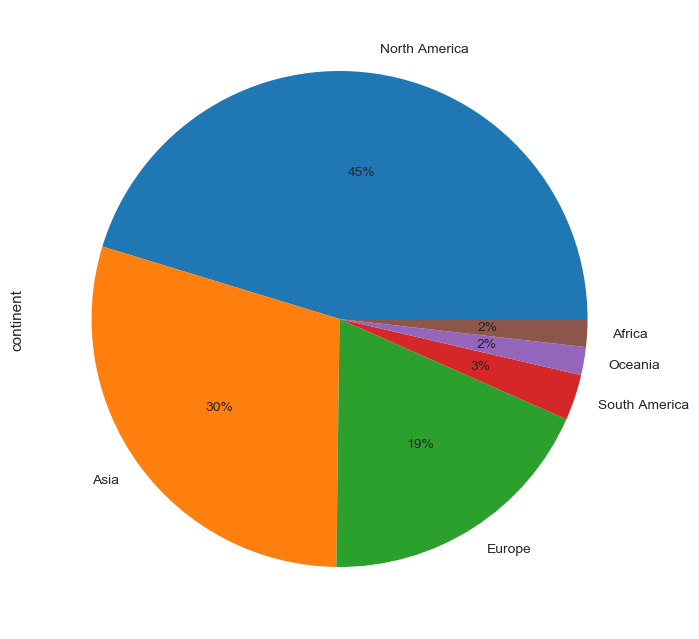

In [22]:
#Movies on Netflix by countinent
plt.rcParams["figure.figsize"] = (8, 10)
data.continent.value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

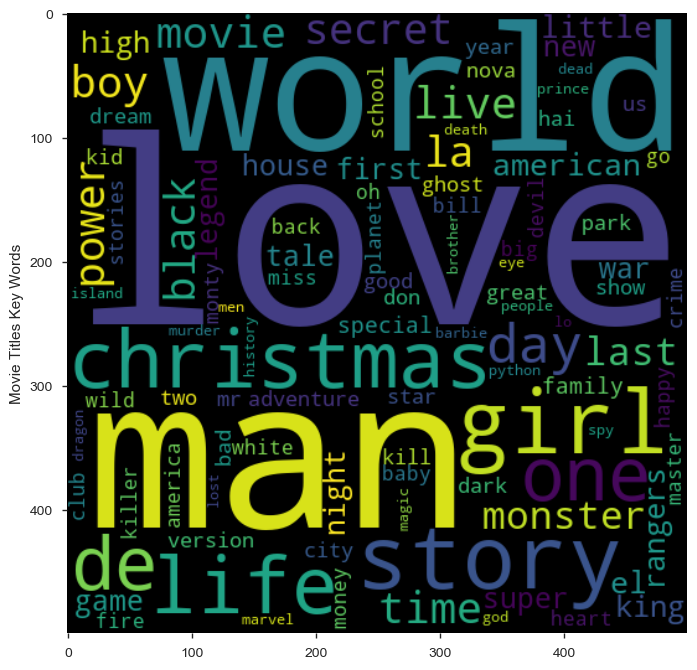

In [23]:
#WordCloud of movie titles
all_txt
wordcloud = WordCloud(width=500, height=500, min_font_size=6, max_font_size=300, max_words=100, collocations=False ).generate(all_txt)
plt.imshow(wordcloud,interpolation='bilinear')
plt.ylabel('Movie Titles Key Words')
plt.grid('')
plt.show()

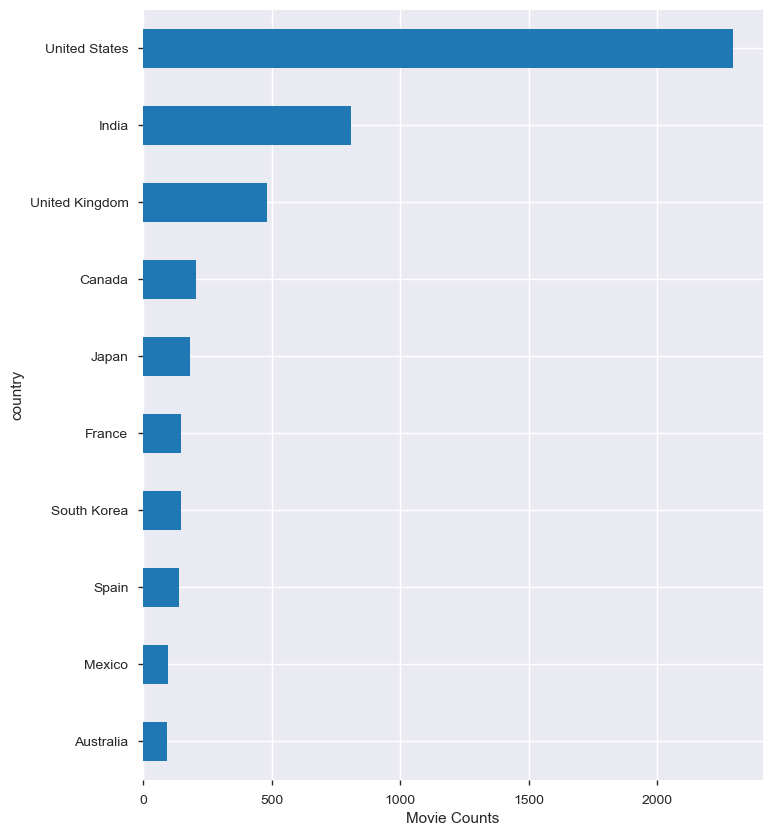

In [24]:
data.groupby('country')['type'].count().nlargest(10).sort_values(ascending=True).plot(kind='barh') 
plt.xlabel('Movie Counts')
plt.show()

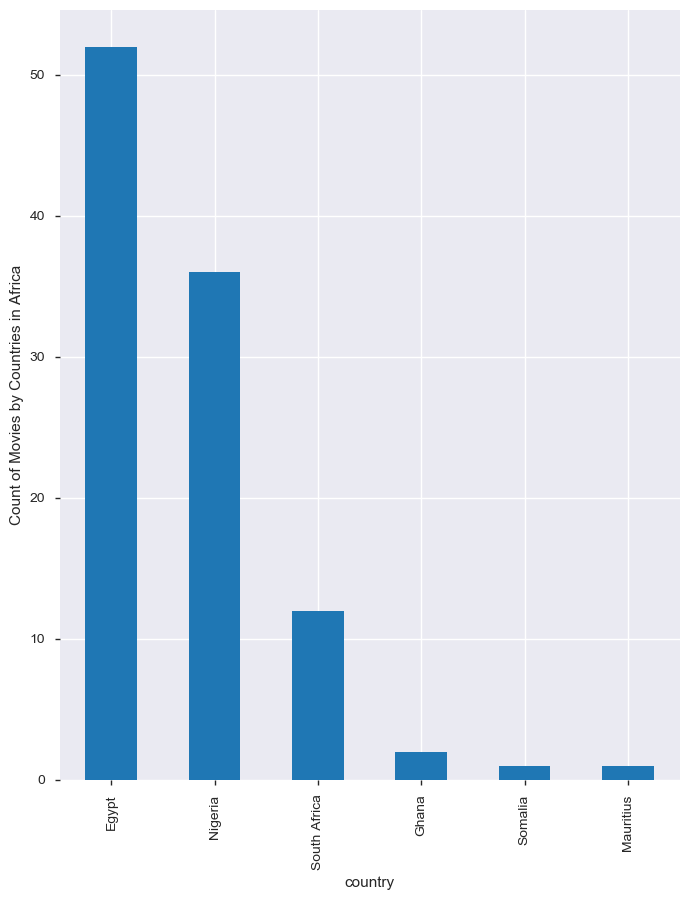

In [25]:
data[data['continent']=='Africa'].groupby('country')['title'].count().sort_values(ascending=False).plot(kind= 'bar')
plt.ylabel('Count of Movies by Countries in Africa')
plt.show()

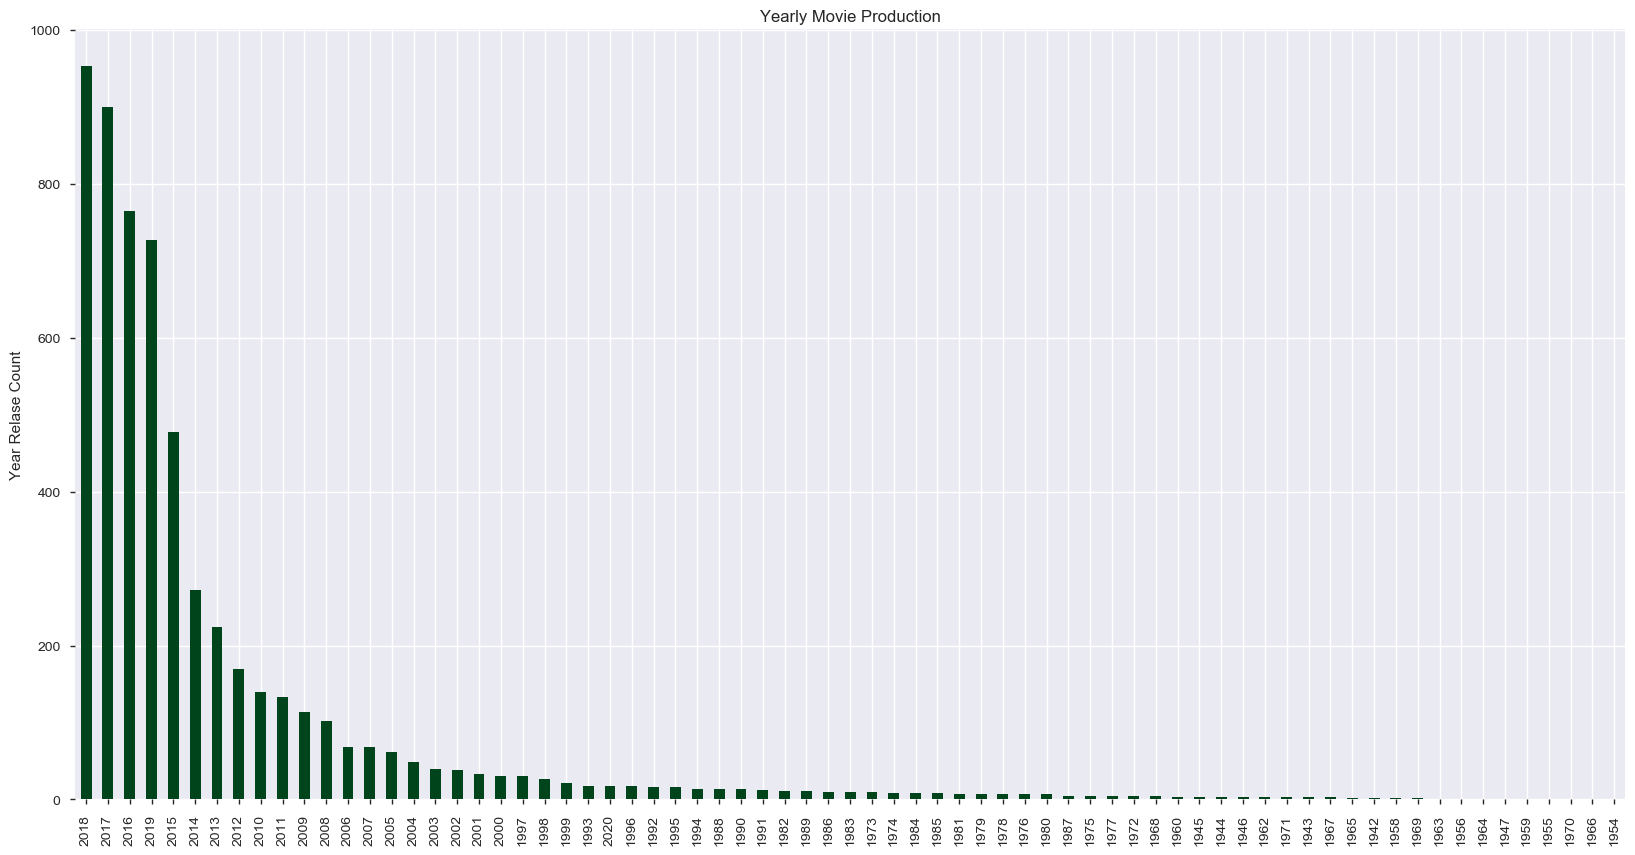

In [26]:
plt.figure(figsize=(20,10))
data['release_year'].value_counts().plot(kind='bar', colormap='Greens_r')
plt.title('Yearly Movie Production')
plt.ylabel('Year Relase Count')
plt.show()

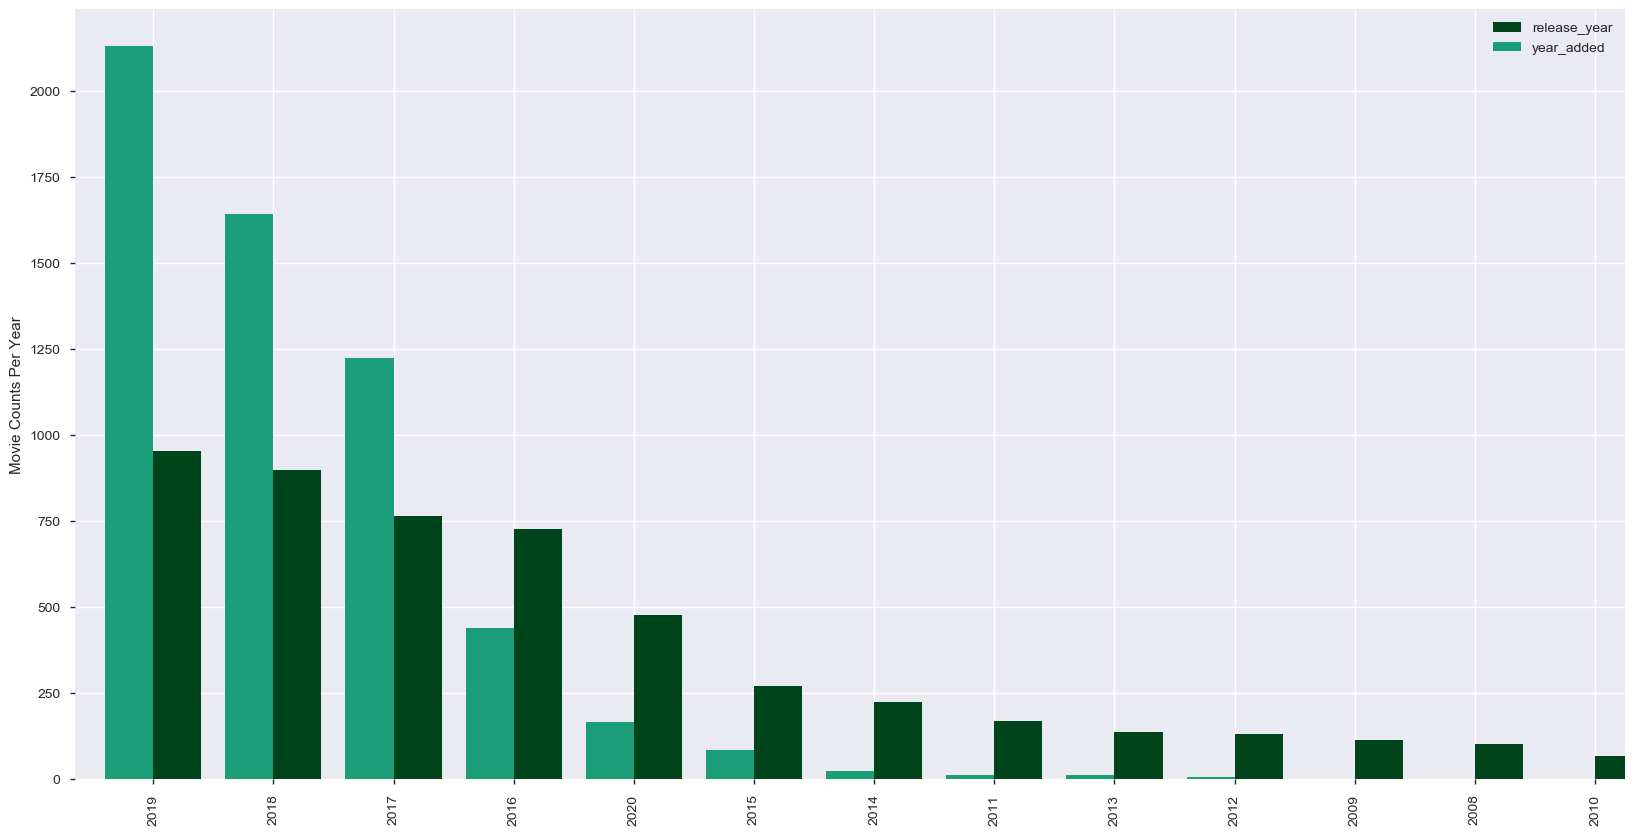

In [27]:
#Until 2017, less movies released in the year make it to netflix.From 2017,much moreolder movies are added
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

#Use ax2 = ax.twinx() if the bars are to have different y_axis in one plot

data['release_year'].value_counts().plot(kind='bar', colormap='Greens_r',width = 0.4, ax=ax, position = 0)
data['year_added'].value_counts().plot(kind='bar', colormap='Dark2',width = 0.4, ax=ax, position = 1)
ax.set_ylabel('Movie Counts Per Year')
ax.legend()
#Used to label the seconday_y: ax2.set_ylabel('A_year')
plt.show()

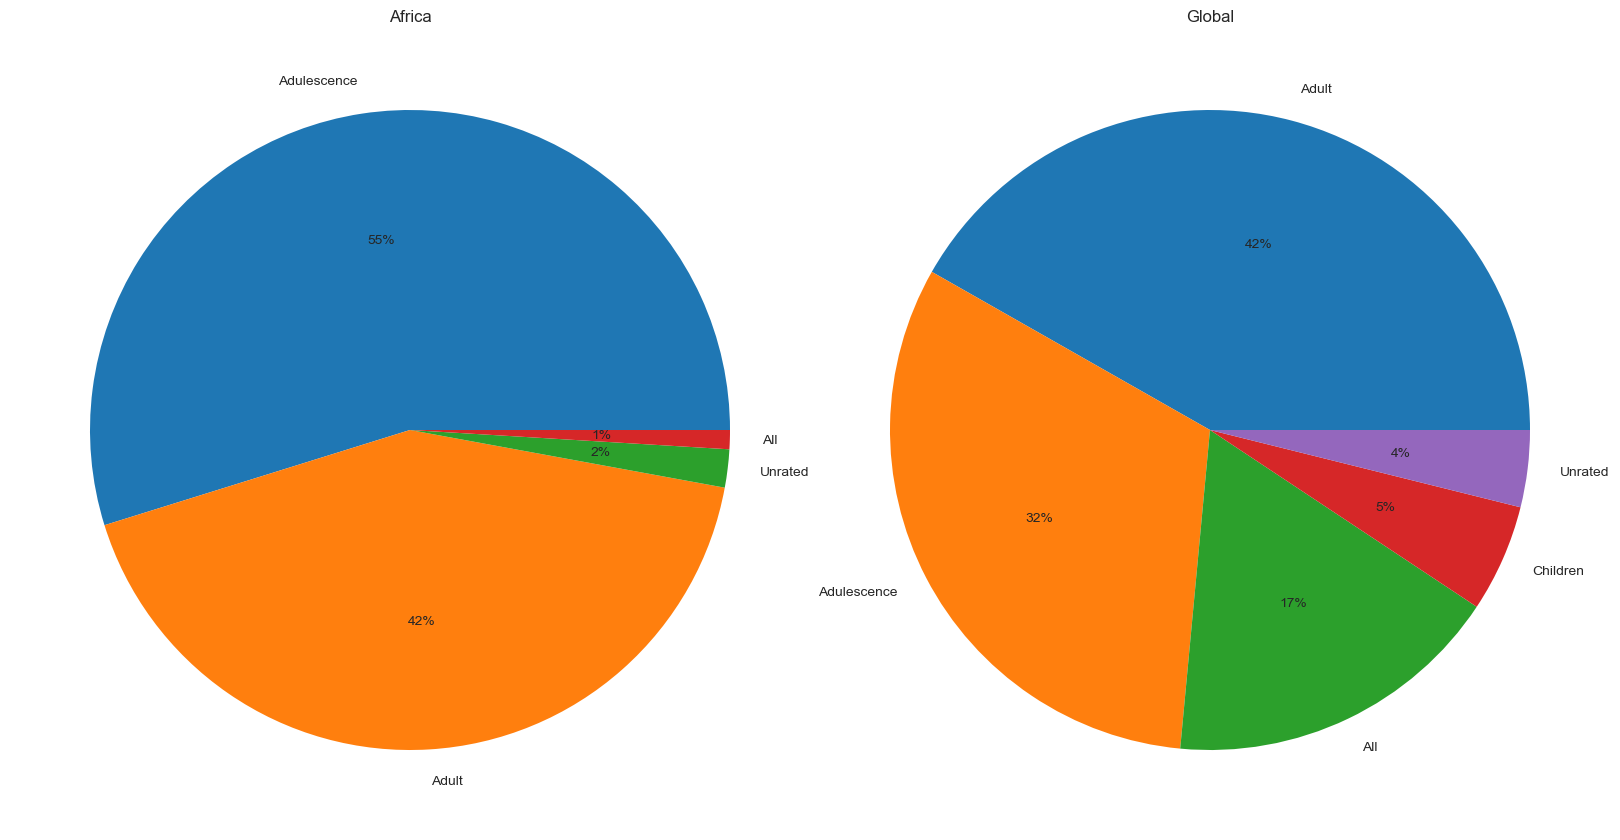

In [28]:
#Global vs Africa distribution of movie audience
fig = plt.figure()
label = ['Adulescence', 'Adult', 'Unrated', 'All']
label2 = ['Adult', 'Adulescence', 'All', 'Children', 'Unrated']

ax = fig.add_axes([0,0,1,1])
ax2 = fig.add_axes([1,0,1,1])

ax.pie(data[data['continent']=='Africa']['audience'].value_counts(), labels = label, autopct='%1.0f%%')
ax2.pie(data['audience'].value_counts(), labels = label2, autopct='%1.0f%%')

ax.set_title('Africa')
ax2.set_title('Global')
plt.show()

In [29]:
#Export Clean Data
date = pd.Timestamp.today().strftime(format = '%d-%m-%Y')
data.to_csv('clean_netflis_data.csv')

# Predictive Modelling

In [30]:
data.head(2)


,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,continent,genre,kind,audience,duration_2
show_id,,,,,,,,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",United States,09-09-2019,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,North America,Children & Family,Single,All,90
80117401,Movie,Jandino: Whatever it Takes,Unknown,Jandino Asporaat,United Kingdom,09-09-2016,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,Europe,Comedy,Single,Adult,94


In [31]:
#Extract the features and label from the clean dataset
feature = data[['type', 'title', 'director', 'cast', 'country', 'year_added', 'release_year','description',
        'continent',  'kind', 'audience']]
label = data['genre']


#Train+Test Split
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = 0.2, random_state =42)


In [32]:
#Separating the data types
text_cols = X_train.select_dtypes(exclude='number').columns.to_list()
num_cols = X_train.select_dtypes(include='number').columns.to_list()
text_cols

['type',
 'title',
 'director',
 'cast',
 'country',
 'description',
 'continent',
 'kind',
 'audience']

In [33]:
def clean_col(data):
    data = data.strip()
    data = re.sub("[\W0-9]", " ", data)
    return data
    

for item in text_cols:
    clean_col(item)

In [34]:
X_train.dtypes

type            object
title           object
director        object
cast            object
country         object
year_added       int32
release_year     int64
description     object
continent       object
kind            object
audience        object
dtype: object

In [35]:
class Concatenator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        res = []
        for row in X:
            res.append(' '.join([word for word in row if word]))
        return res

In [36]:
#Text and numerical Pipelines
text_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value = '')),
    ('concat', Concatenator()),
    ('vectorize',CountVectorizer())
#     ('encode', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

ct = ColumnTransformer(remainder='drop',
                      transformers=[
                          ('text_pipe', text_pipe, text_cols),
                          ('num_pipe', num_pipe, num_cols)
                      ])

In [37]:
model =Pipeline([
    ('ct', ct),
#     ('dim_red', TruncatedSVD(n_components=50)),
    ('classifier', LogisticRegression(solver='liblinear', multi_class='auto'))
])

In [38]:
#Fitting the model
model.fit(X_train, y_train);

predictions = model.predict(X_test)
predictions

array(['Drama', 'Comedy', 'Documentary', ..., 'Action',
       'Children & Family', 'Documentary'], dtype=object)

In [39]:
accuracy_score(y_test, predictions)

0.56

In [40]:
#Parameter Tuning
param_grid = {'penalty':['l1', 'l2'], 'C' : np.logspace(-4, 4, 20), 'solver':['liblinear']}
clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5, verbose = -1)


clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Nnameka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'All'

In [ ]:
#Feature Selection...
fs = SelectKBest(score_func='chi2', k='all')
fs.fit(X_train, y_train)